# ⚛️ VQE Ground State of H₂ — Noise Scans & Fidelity

This notebook explores how **noise** affects the **Variational Quantum Eigensolver (VQE)** for the hydrogen
molecule **H₂**.

We do this in two complementary ways:

1. **Manual demo (educational):**
   - Build a noisy PennyLane QNode by hand.
   - Add **depolarizing** and **amplitude-damping** channels.
   - Watch how a simple VQE optimisation behaves under noise.

2. **Package-level scans (production-ready):**
   - Use high-level functions from `vqe.core`:
     - `run_vqe`
     - `run_vqe_noise_sweep`
     - `run_vqe_multi_seed_noise`
   - Automatically:
     - cache results
     - inject noise correctly
     - compute **energy shifts ΔE**
     - compute **fidelity vs. a noiseless reference**
     - generate and save plots to your unified `images/` directory.

We will:

- Build a **noiseless reference** VQE state.
- Sweep over **noise strengths**.
- Compare **ΔE vs. noise** and **fidelity vs. noise**.
- Run a **multi-seed noise study** to see statistical behaviour.


In [1]:
# Imports & setup

import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.core import (
    run_vqe,
    run_vqe_noise_sweep,
    run_vqe_multi_seed_noise,
)

from vqe_qpe_common.plotting import IMG_DIR

# Basic H2 setup for the manual demo
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414],
])
basis = "sto-3g"

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    basis=basis,
    active_electrons=2,
    active_orbitals=2,
)

num_wires = qubits
print(f"H₂ with basis={basis}: {num_wires} qubits")


H₂ with basis=sto-3g: 4 qubits


## 1️⃣ Manual Noisy VQE Demo (Educational Only)

In this first section we **do not use** the package API.  
Instead, we:

- build a small **TwoQubit-RY-CNOT ansatz** by hand
- add:
  - **DepolarizingChannel(p_dep)**
  - **AmplitudeDamping(p_amp)**
- optimise with a simple **GradientDescent** optimiser

This is purely to *illustrate* how noise is injected at the circuit level.  
Later, we let the **package** handle all of this for us.


[demo] Step 01/30: E = 1.295346 Ha
[demo] Step 02/30: E = 1.292471 Ha
[demo] Step 03/30: E = 1.288978 Ha
[demo] Step 04/30: E = 1.284737 Ha
[demo] Step 05/30: E = 1.279591 Ha
[demo] Step 06/30: E = 1.273352 Ha
[demo] Step 07/30: E = 1.265796 Ha
[demo] Step 08/30: E = 1.256657 Ha
[demo] Step 09/30: E = 1.245621 Ha
[demo] Step 10/30: E = 1.232318 Ha
[demo] Step 11/30: E = 1.216322 Ha
[demo] Step 12/30: E = 1.197139 Ha
[demo] Step 13/30: E = 1.174213 Ha
[demo] Step 14/30: E = 1.146923 Ha
[demo] Step 15/30: E = 1.114595 Ha
[demo] Step 16/30: E = 1.076517 Ha
[demo] Step 17/30: E = 1.031969 Ha
[demo] Step 18/30: E = 0.980266 Ha
[demo] Step 19/30: E = 0.920814 Ha
[demo] Step 20/30: E = 0.853182 Ha
[demo] Step 21/30: E = 0.777187 Ha
[demo] Step 22/30: E = 0.692978 Ha
[demo] Step 23/30: E = 0.601114 Ha
[demo] Step 24/30: E = 0.502608 Ha
[demo] Step 25/30: E = 0.398935 Ha
[demo] Step 26/30: E = 0.291976 Ha
[demo] Step 27/30: E = 0.183902 Ha
[demo] Step 28/30: E = 0.077013 Ha
[demo] Step 29/30: E

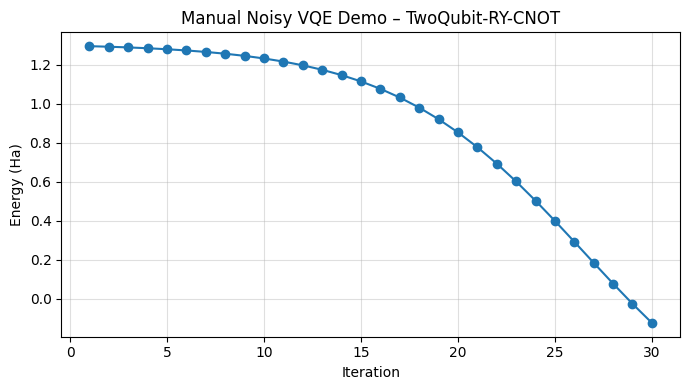

'/workspaces/Variational_Quantum_Eigensolver/images/H2_Manual_Noisy_VQE_Demo.png'

In [2]:
# Simple 2-qubit ansatz: RY on qubit 0 + CNOT(0→1) + RY on qubit 1
def two_qubit_ry_cnot(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[1], wires=wires[1])


# Noise parameters for this demo
p_dep_demo = 0.02
p_amp_demo = 0.04

dev_noisy = qml.device("default.mixed", wires=num_wires)

@qml.qnode(dev_noisy, diff_method="finite-diff")
def noisy_energy(params):
    # Apply ansatz
    two_qubit_ry_cnot(params, wires=[0, 1])

    # Apply noise channels to each qubit
    for w in range(num_wires):
        qml.DepolarizingChannel(p_dep_demo, wires=w)
        qml.AmplitudeDamping(p_amp_demo, wires=w)

    return qml.expval(H)


# Run a tiny VQE loop manually (for illustration only)
opt = qml.GradientDescentOptimizer(stepsize=0.1)
params = 0.1 * np.random.randn(2, requires_grad=True)

energies_demo = []
n_steps_demo = 30

for step in range(n_steps_demo):
    params, e_prev = opt.step_and_cost(noisy_energy, params)
    e_val = float(noisy_energy(params))
    energies_demo.append(e_val)
    print(f"[demo] Step {step+1:02d}/{n_steps_demo}: E = {e_val:.6f} Ha")


plt.figure(figsize=(7, 4))
plt.plot(range(1, n_steps_demo + 1), energies_demo, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("Manual Noisy VQE Demo – TwoQubit-RY-CNOT")
plt.grid(True, alpha=0.4)
plt.tight_layout()

demo_fname = os.path.join(IMG_DIR, "H2_Manual_Noisy_VQE_Demo.png")
plt.savefig(demo_fname, dpi=300, bbox_inches="tight")
plt.show()

demo_fname


## 2️⃣ Package-Level Noiseless Reference

Now we switch to the **package API**.

We first compute a **noiseless reference state** using `run_vqe`:

- molecule: `H2`
- ansatz: `RY-CZ` (or `UCCSD`, etc.)
- optimiser: `Adam`
- noise: off (`noisy=False`)

`run_vqe` returns:

- `energy` — final energy (Ha)
- `energies` — convergence trace
- `final_state_real`, `final_state_imag` — statevector


In [3]:
# High-level VQE (noiseless reference) using the package

ref_result = run_vqe(
    molecule="H2",
    ansatz_name="RY-CZ",      # keep this lightweight for the scan
    optimizer_name="Adam",
    n_steps=50,
    stepsize=0.2,
    noisy=False,
    plot=True,                # will use vqe.visualize.plot_convergence
    seed=0,
    force=False,
)

reference_energy = ref_result["energy"]
psi_real = np.array(ref_result["final_state_real"])
psi_imag = np.array(ref_result["final_state_imag"])
reference_state = psi_real + 1j * psi_imag

reference_energy



📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__821ace67521d.json


-1.111054843431207

## 3️⃣ Single-Seed Noise Sweep (Package API)

We now call:

```python
run_vqe_noise_sweep(...)
```

This function:
- computes a noiseless reference internally
- sweeps over a range of noise probabilities
- for each noise level:
  - runs VQE with noise
  - computes ΔE = E_noisy − E_reference
  - computes fidelity vs. the reference state
- produces a two-panel plot:
  - ΔE vs noise
  - fidelity vs noise
  


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__a8709a2afbe0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__e08edbda183a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__91d11ac31b7c.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__52e4591584ec.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__97e168fed872.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__c30c1c2d5c8a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__cb4f3e891108.json
📁 Saved → /workspaces/Variational_Quantum_Eigensolver/images/vqe/VQE_Noise_Stat

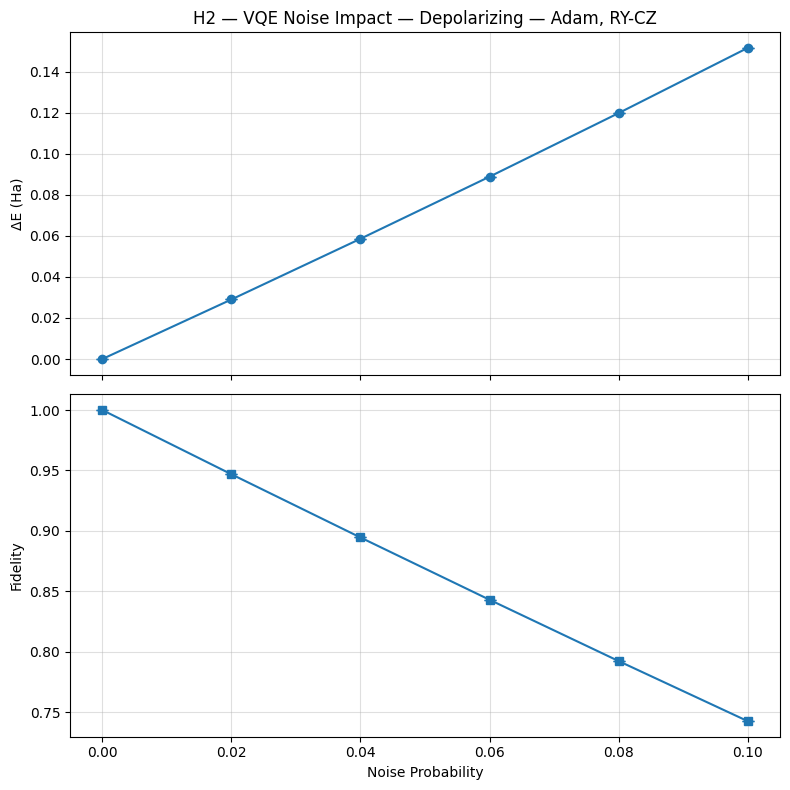


✅ Noise sweep complete for H2 (RY-CZ, Adam)


In [4]:
# Single-seed noise sweep with depolarizing noise only

run_vqe_noise_sweep(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),  # 0.00 → 0.10
    amplitude_damping_probs=np.zeros(6),            # pure depolarizing
    force=False,
    mapping="jordan_wigner",
)


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__a8709a2afbe0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__e08edbda183a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__d1ff375817fd.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__32a1236cd4c1.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__d9cbfbf98b0b.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__7cb746c1e75b.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__8a1a43c96b09.json
📁 Saved → /workspaces/Variational_Quantum_Eigensolver/images/vqe/VQE_Noise_Stat

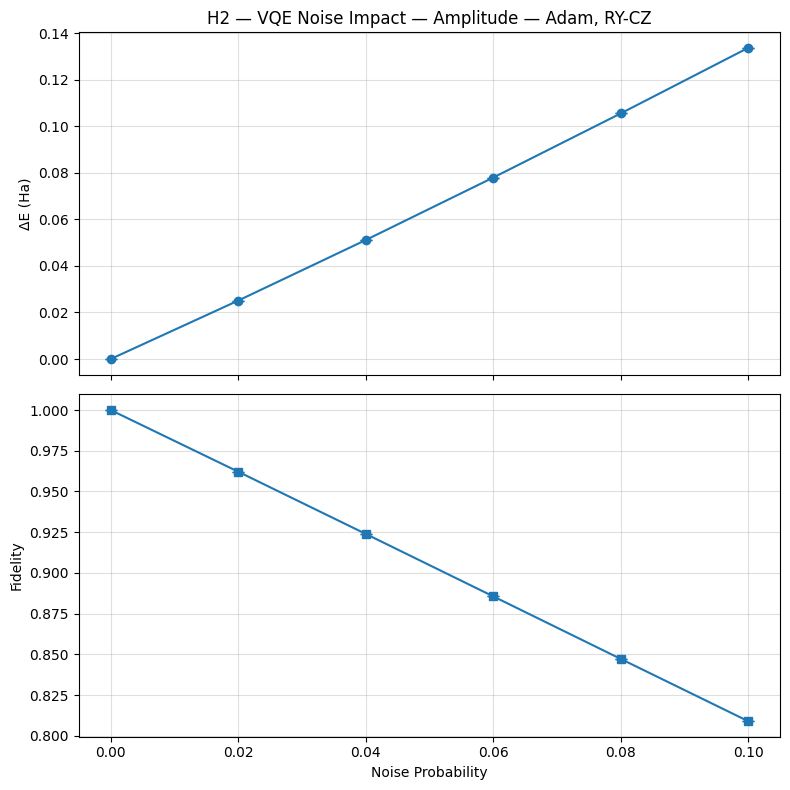


✅ Noise sweep complete for H2 (RY-CZ, Adam)


In [5]:
# Single-seed noise sweep with amplitude damping only

run_vqe_noise_sweep(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    depolarizing_probs=np.zeros(6),                 # pure amplitude damping
    amplitude_damping_probs=np.arange(0.0, 0.11, 0.02),
    force=False,
    mapping="jordan_wigner",
)


## 4️⃣ Multi-Seed Noise Study (Package API)

To capture **statistical behaviour** of VQE under noise, we use:

```python
run_vqe_multi_seed_noise(...)
```

This function:
- picks a set of seeds (default 0–4, or user-specified)
- for each noise level:
  - runs VQE with noise for each seed
  - computes ΔE and fidelity relative to a noiseless multi-seed reference
- aggregates:
  - mean & std of ΔE
  - mean & std of fidelity
- plots:
  - ΔE vs noise (with error bars)
  - fidelity vs noise (with error bars)
  
All plots are saved automatically.


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__a8709a2afbe0.json
Step 01/30: E = 0.676009 Ha
Step 02/30: E = 0.602924 Ha
Step 03/30: E = 0.485968 Ha
Step 04/30: E = 0.336314 Ha
Step 05/30: E = 0.172726 Ha
Step 06/30: E = 0.020335 Ha
Step 07/30: E = -0.097872 Ha
Step 08/30: E = -0.185998 Ha
Step 09/30: E = -0.272948 Ha
Step 10/30: E = -0.372510 Ha
Step 11/30: E = -0.485273 Ha
Step 12/30: E = -0.607519 Ha
Step 13/30: E = -0.733146 Ha
Step 14/30: E = -0.853940 Ha
Step 15/30: E = -0.960236 Ha
Step 16/30: E = -1.042521 Ha
Step 17/30: E = -1.093880 Ha
Step 18/30: E = -1.112456 Ha
Step 19/30: E = -1.102505 Ha
Step 20/30: E = -1.073102 Ha
Step 21/30: E = -1.035102 Ha
Step 22/30: E = -0.998137 Ha
Step 23/30: E = -0.968956 Ha
Step 24/30: E = -0.951199 Ha
Step 25/30: E = -0.945940 Ha
Step 26/30: E = -0.952429 Ha
Step 27/30: E = -0.968715 Ha
Step 28/30: E = -0.992089 Ha
Step 29/30: E = -1

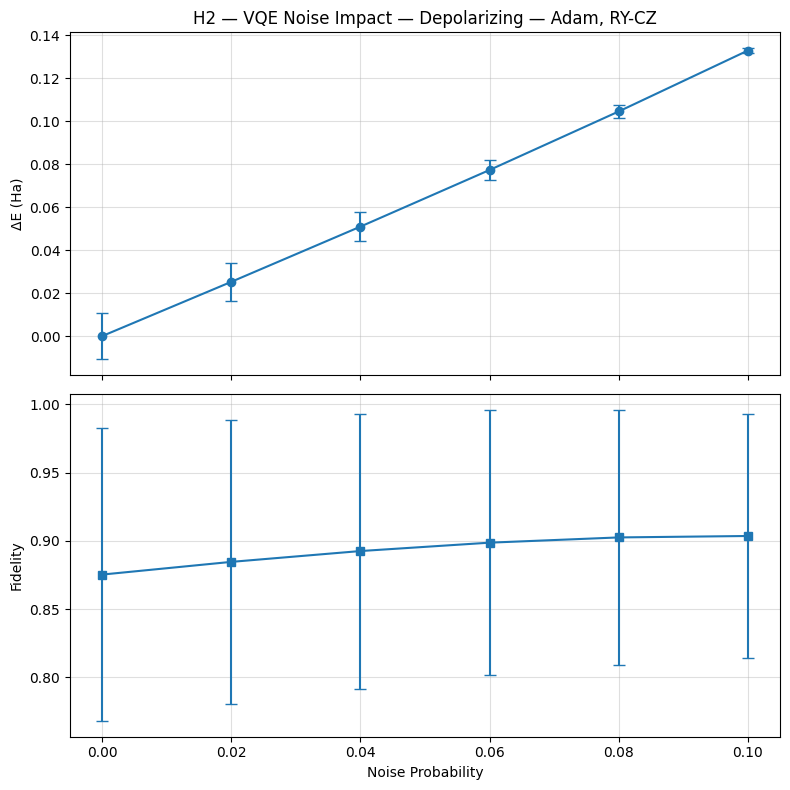


✅ Multi-seed noise study complete for H2


In [6]:
# Multi-seed noise study – depolarizing noise

run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    stepsize=0.2,
    seeds=np.arange(0, 5),
    noise_type="depolarizing",
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),
    force=False,
    mapping="jordan_wigner",
)


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__a8709a2afbe0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s1__f4025b548242.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s2__5c18ed9e16b8.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s3__532e5734d599.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s4__dfdc5b90a02d.json
Reference mean energy = -1.050301 Ha

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__e08edbda183a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s1__99f

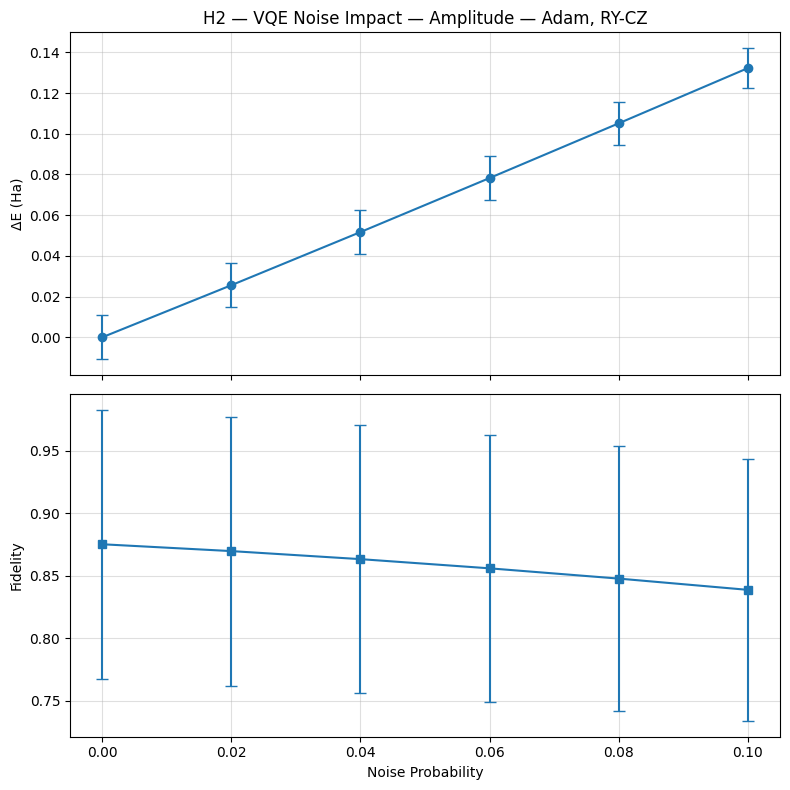


✅ Multi-seed noise study complete for H2


In [7]:
# Multi-seed noise study – amplitude damping noise

run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    stepsize=0.2,
    seeds=np.arange(0, 5),
    noise_type="amplitude",
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),  # reused as amplitude probs internally
    force=False,
    mapping="jordan_wigner",
)


## 5️⃣ Summary

In this notebook we:

1. **Manually constructed** a noisy VQE circuit:
   - explicit `DepolarizingChannel` and `AmplitudeDamping`
   - quick GradientDescent optimisation
   - convergence under a fixed noise level

2. **Used the package API** to:
   - run a **noiseless reference VQE** (`run_vqe`)
   - perform **single-seed noise sweeps** (`run_vqe_noise_sweep`)
   - perform **multi-seed noise statistics** (`run_vqe_multi_seed_noise`)
   - automatically generate and save:
     - ΔE vs noise
     - fidelity vs noise
     - convergence plots

This notebook now cleanly separates:

- **Educational internals** (manual QNode section)
- **Production-grade workflows** (package functions)

all while using your **centralised noise, plotting, and caching infrastructure**.
